In [1]:
import requests
from datetime import datetime

headers = {'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/130.0.0.0 Safari/537.36'}
now = datetime.now()
tudoanh_data_url = 'https://cafef.vn/du-lieu/Ajax/PageNew/DataHistory/GDTuDoanh.ashx?Symbol={}&StartDate=11/01/2022&EndDate={}&PageIndex=1&PageSize=1000'
price_data_url = 'https://iboard-api.ssi.com.vn/statistics/company/ssmi/stock-info?symbol={}&page=1&pageSize=1000&fromDate=01/11/2022&toDate={}'
list_symbol_url = 'https://iboard-query.ssi.com.vn/stock/exchange/hose?boardId=MAIN'

In [7]:
data = {}; total_val = {}
def get_data(symbol):
    
    data[symbol] = {}
    tudoanh_data_res = requests.get(tudoanh_data_url.format(symbol, now.strftime('%m/%d/%Y')), headers=headers).json()
    price_data_res = requests.get(price_data_url.format(symbol, now.strftime('%d/%m/%Y')), headers=headers).json()

    total_val[symbol] = (tudoanh_data_res['Data']['Data']['TongGtMua'] + tudoanh_data_res['Data']['Data']['TongGtBan']) / 1e9
    
    for row in tudoanh_data_res['Data']['Data']['ListDataTudoanh']:
        date = row['Date']
        data[symbol][date] = {'BuyVolume': row['KLcpMua'], 'SellVolume': row['KlcpBan'], 'BuyValue': row['GtMua'], 'SellValue': row['GtBan']}
        
    for row in price_data_res['data']:
        date = row['tradingDate']
        if date not in data[symbol]:
            data[symbol][date] = {}
            
        data[symbol][date]['ClosePrice'] = row['close']
        data[symbol][date]['ClosePriceAdjusted'] = row['closePriceAdjusted']

In [ ]:
list_symbol_res = requests.get(list_symbol_url, headers=headers).json()['data']
list_symbol = [r['stockSymbol'] for r in list_symbol_res]
for symbol in list_symbol:
    get_data(symbol)

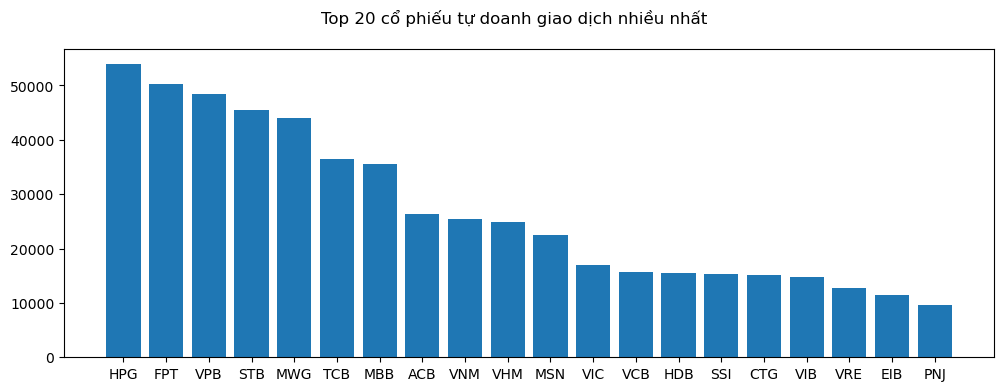

In [70]:
import matplotlib.pyplot as plt
total_val_sorted = {k: v for k, v in sorted(total_val.items(), key=lambda item: item[1], reverse=True)}
symbols = [k for k in total_val_sorted][:20]
values = [total_val_sorted[k] for k in symbols]

plt.figure(figsize=(12, 4))
plt.bar(symbols, values)
plt.suptitle('Top 20 cổ phiếu tự doanh giao dịch nhiều nhất')
# plt.savefig('img/top20_tudoanh.png')
plt.show()

In [101]:
def compute_profit(symbol):
    
    list_date = [k for k in data[symbol]]
    list_date.reverse()
    
    mdata = data[symbol]
    
    total_buy_volume = 0; total_buy_value = 0
    total_sell_volume = 0; total_sell_value = 0
    
    all_profit = []
    
    for date in list_date:

        if 'ClosePriceAdjusted' in mdata[date]:
            rate = float(mdata[date]['ClosePriceAdjusted']) / float(mdata[date]['ClosePrice'])
        else: # Có thể du dữ liệu bị lỗi, hoặc tự doanh mua bán thỏa thuận một lượng không đáng kể, có thể bỏ qua
            continue
    
        if 'BuyVolume' in mdata[date]:
            buy_volume_adjusted = mdata[date]['BuyVolume'] / rate
        else:
            buy_volume_adjusted = 0
        if 'SellVolume' in mdata[date]:
            sell_volume_adjusted = mdata[date]['SellVolume'] / rate
        else:
            sell_volume_adjusted = 0
    
        total_buy_volume += buy_volume_adjusted
        total_sell_volume += sell_volume_adjusted
    
        if 'BuyValue' in mdata[date]:
            total_buy_value += mdata[date]['BuyValue']
        if 'SellValue' in mdata[date]:
            total_sell_value += mdata[date]['SellValue']
    
        profit = (float(mdata[date]['ClosePriceAdjusted']) * total_buy_volume - total_buy_value) + (total_sell_value - float(mdata[date]['ClosePriceAdjusted']) * total_sell_volume)
        all_profit.append(profit / 1e9)
        
    return list_date, all_profit

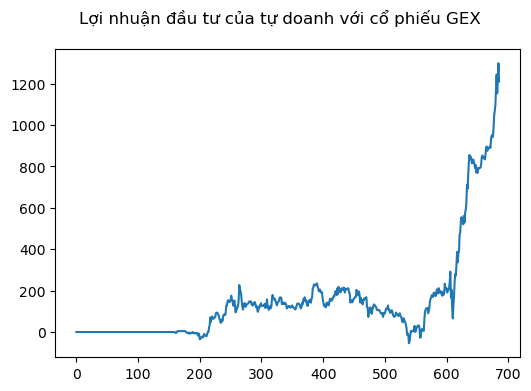

In [102]:
symbol = 'GEX'
list_date, all_profit = compute_profit(symbol)
plt.figure(figsize=(6, 4))
plt.suptitle('Lợi nhuận đầu tư của tự doanh với cổ phiếu ' + symbol)
plt.plot(all_profit)
# plt.savefig('img/tudoanh_{}.png'.format(symbol))
plt.show()

In [108]:
profit_lastday = {}
for symbol in list_symbol:
    _, all_profit = compute_profit(symbol)
    profit_lastday[symbol] = all_profit[-1]
sum([profit_lastday[k] for k in profit_lastday])

-49107.07527795682

In [ ]:
{k: v for k, v in sorted(profit_lastday.items(), key=lambda item: item[1], reverse=True)}

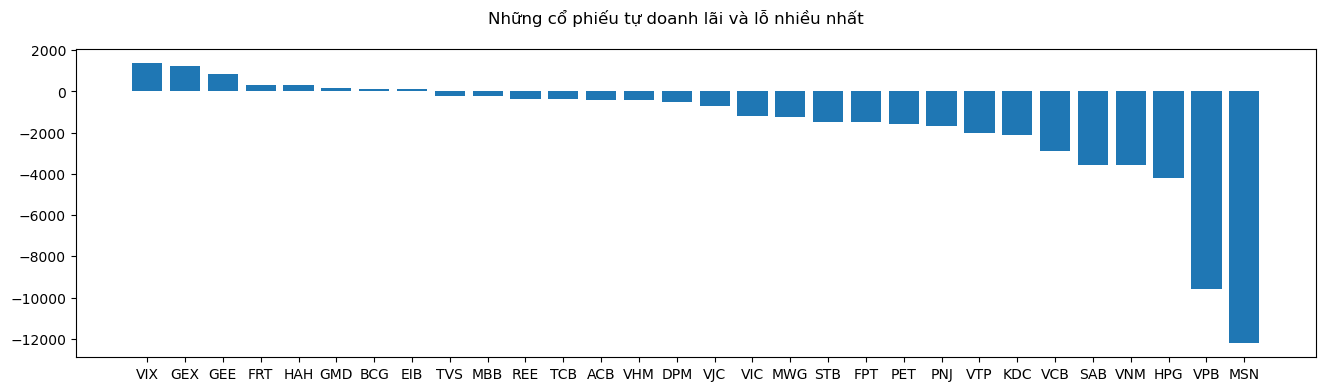

In [114]:
profit_lastday_ = {k: v for k, v in sorted(profit_lastday.items(), key=lambda item: item[1], reverse=True) if v > 100 or v < -200}

symbols = [k for k in profit_lastday_]
values = [profit_lastday_[k] for k in profit_lastday_]

plt.figure(figsize=(16, 4))
plt.bar(symbols, values)
plt.suptitle('Những cổ phiếu tự doanh lãi và lỗ nhiều nhất')
plt.savefig('img/top_tudoanh_.png')
plt.show()